In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Usando cadenas sin formato (raw strings)
train_dir = r'C:\Users\claud\OneDrive\Escritorio\Diplomado Inteligencia Artificial Aplicada al Control Industrial\MODULO 2\fruits-360-original-size\fruits-360-original-size\Training'
validation_dir = r'C:\Users\claud\OneDrive\Escritorio\Diplomado Inteligencia Artificial Aplicada al Control Industrial\MODULO 2\fruits-360-original-size\fruits-360-original-size\Test'

# Preprocesamiento y aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Evaluar el modelo
loss, accuracy = model.evaluate(validation_generator)
print(f'Pérdida: {loss}, Precisión: {accuracy}')

Found 6231 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


C:\Users\claud\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


C:\Users\claud\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.1311 - loss: 2.8449 - val_accuracy: 0.4228 - val_loss: 1.6133
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.4138 - loss: 1.7312 - val_accuracy: 0.7508 - val_loss: 0.8269
Epoch 3/5
  6/195 ━━━━━━━━━━━━━━━━━━━━ 6:26 2s/step - accuracy: 0.5559 - loss: 1.2628

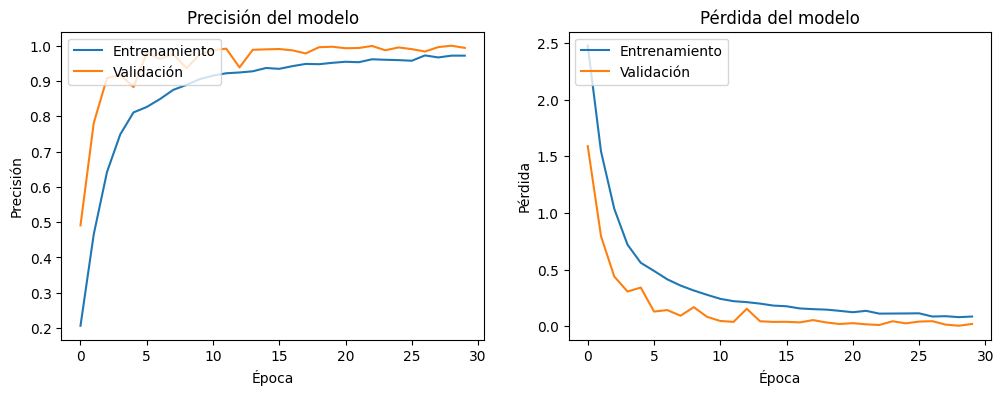

In [9]:
import matplotlib.pyplot as plt

# Graficar precisión del entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='upper left')

# Graficar pérdida del entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(loc='upper left')

plt.show()

97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step


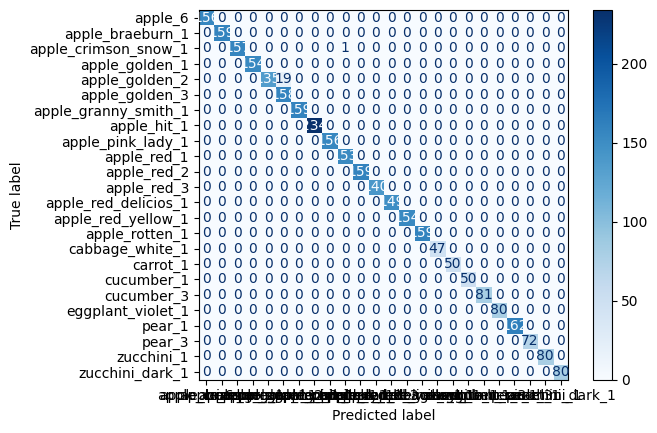

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las etiquetas verdaderas y predichas
validation_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()

# Usando __next__() en lugar de next()
y_true = np.concatenate([next(validation_generator)[1] for i in range(validation_steps)])
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Realiza una predicción inicial para asegurarte de que el modelo ha sido llamado
validation_generator.reset()  # Asegúrate de que el generador esté en el inicio
sample_batch = next(iter(validation_generator))
_ = model.predict(sample_batch[0])

# Crear el modelo intermedio usando el nombre correcto de la capa 'flatten_1'
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('flatten_1').output)
intermediate_output = intermediate_layer_model.predict(validation_generator, steps=validation_steps)

# Reducir la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(intermediate_output)

# Obtener las etiquetas verdaderas y predichas
validation_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
y_true = np.concatenate([next(validation_generator)[1] for i in range(validation_steps)])
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Graficar las características reducidas en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=y_true_classes, palette='viridis')
plt.title('PCA de las características de la capa intermedia')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Clase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


NameError: name 'validation_generator' is not defined